<a href="https://colab.research.google.com/github/yanaySG/YOLOV3/blob/main/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
print(torch.cuda.is_available())

True


Building a YOLOv3 Object Detector with Darknet in the Cloud 
(GPU ENABLED)

In [25]:
#!rm -rf darknet
%rm -rf darknet

In [26]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15521, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15521 (delta 0), reused 5 (delta 0), pack-reused 15514
Receiving objects: 100% (15521/15521), 14.19 MiB | 6.55 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.


In [27]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile


/content/darknet/darknet


In [28]:
!nvidia-smi

Sun May 28 23:17:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [30]:
#!export LD_LIBRARY_PATH=/path/of/libcuda.so.1:$LD_LIBRARY_PATH

In [31]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 

In [32]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-05-28 23:18:52--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  20.6MB/s    in 12s     

2023-05-28 23:19:05 (19.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [33]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [34]:
# The object detector can be run using the following command
#!./darknet detect <path to config> <path to weights> <path to image>

# run darknet detection
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

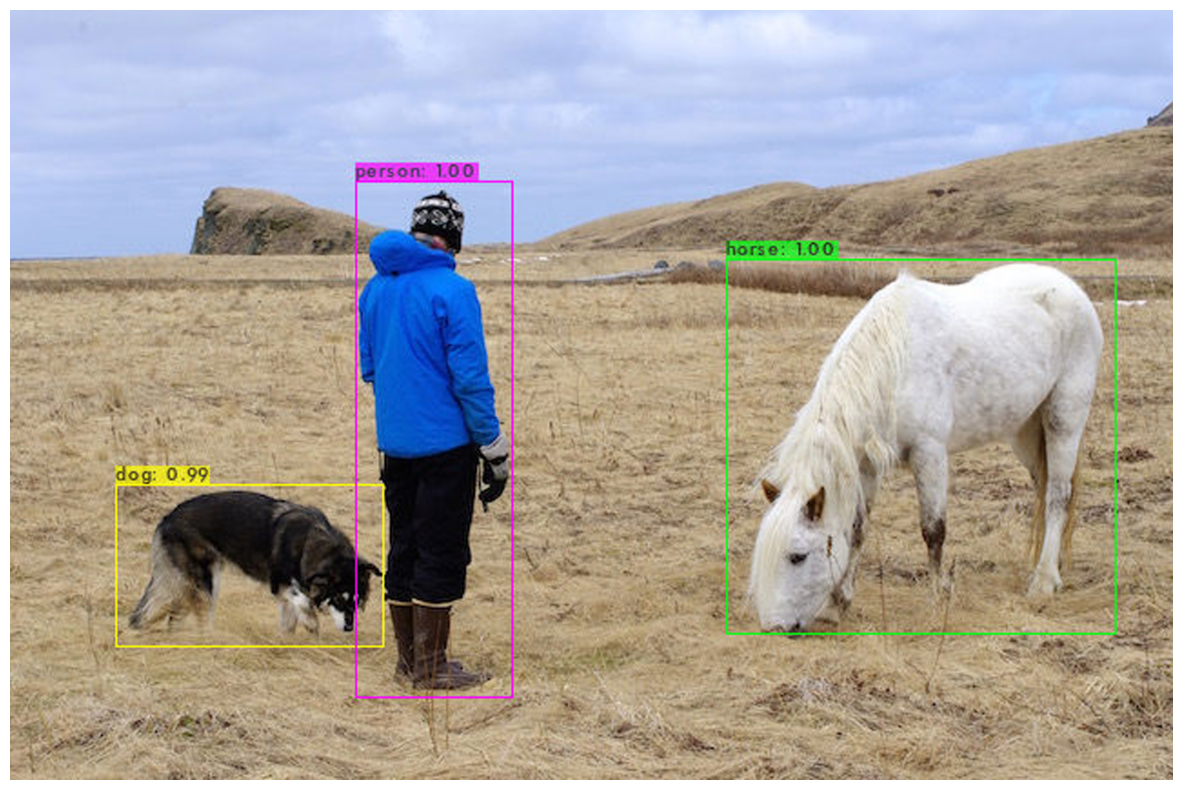

In [35]:
# show image using our helper function
imShow('predictions.jpg')

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

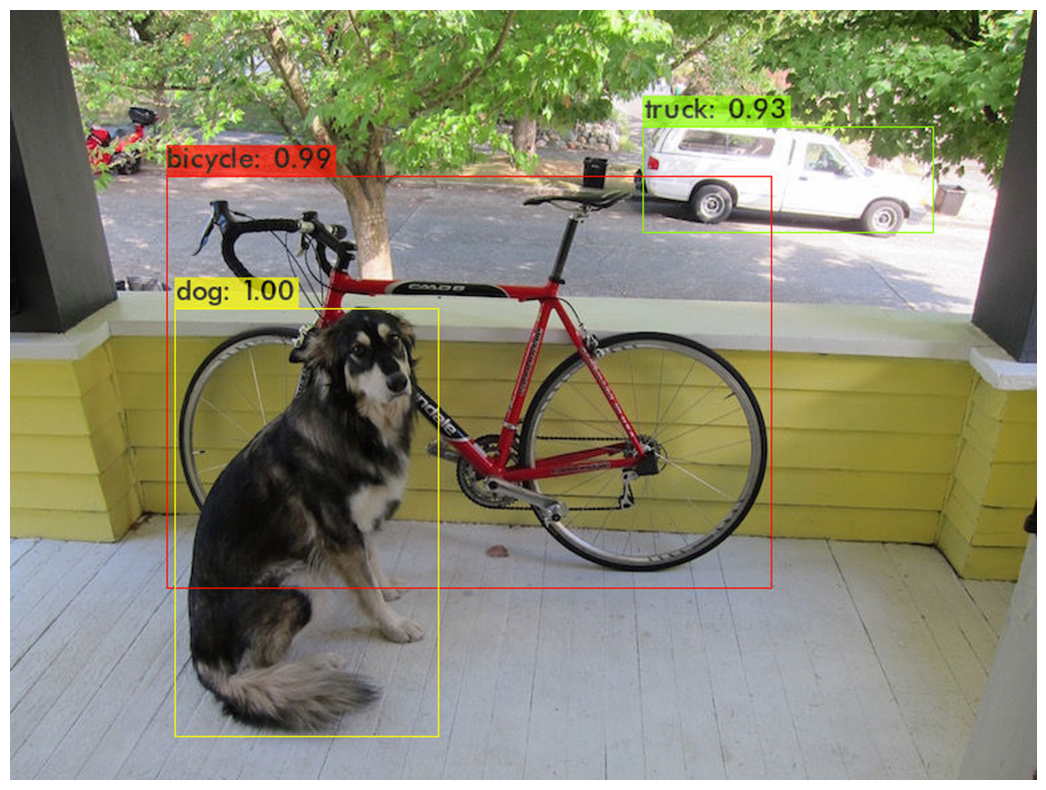

In [36]:
# look we can run another detection
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg
imShow('predictions.jpg')

In [37]:
# this stops 'Runtime/Run all' at this cell by causing an error
assert False

AssertionError: ignored

Uploading Local Files to Use

In [38]:
# upload an image to root directory (I uploaded an image called street.jpg, you can upload anything)
%cd ..
upload() # example: street.jpg

/content/darknet


Saving street.jpg to street.jpg
saved file street.jpg


/content/darknet/darknet
 CUDA-version: 11080 (12000), cuDNN: 8.7.0, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF


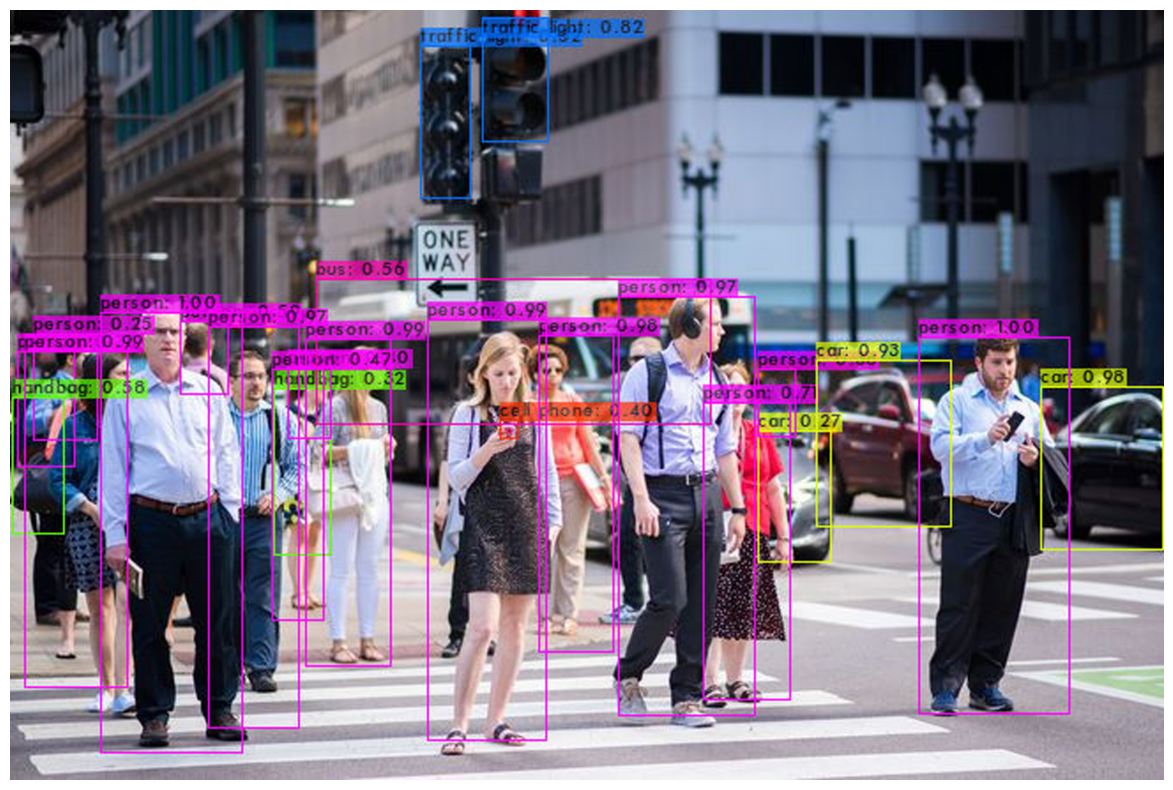

In [39]:
# make sure you are in the darknet folder to run the detections command!
%cd darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights ../street.jpg
imShow('predictions.jpg')

Uploading Google Drive Files to Use

In [40]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content/darknet
Mounted at /content/gdrive


In [41]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists
'Colab Notebooks'  'Indoor positioning'  'Reporte de Trabajo.gdoc'   YOLO
 images		   'My Drive'		  TensorFlow		     YOLO2


/content/darknet/darknet
 CUDA-version: 11080 (12000), cuDNN: 8.7.0, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF


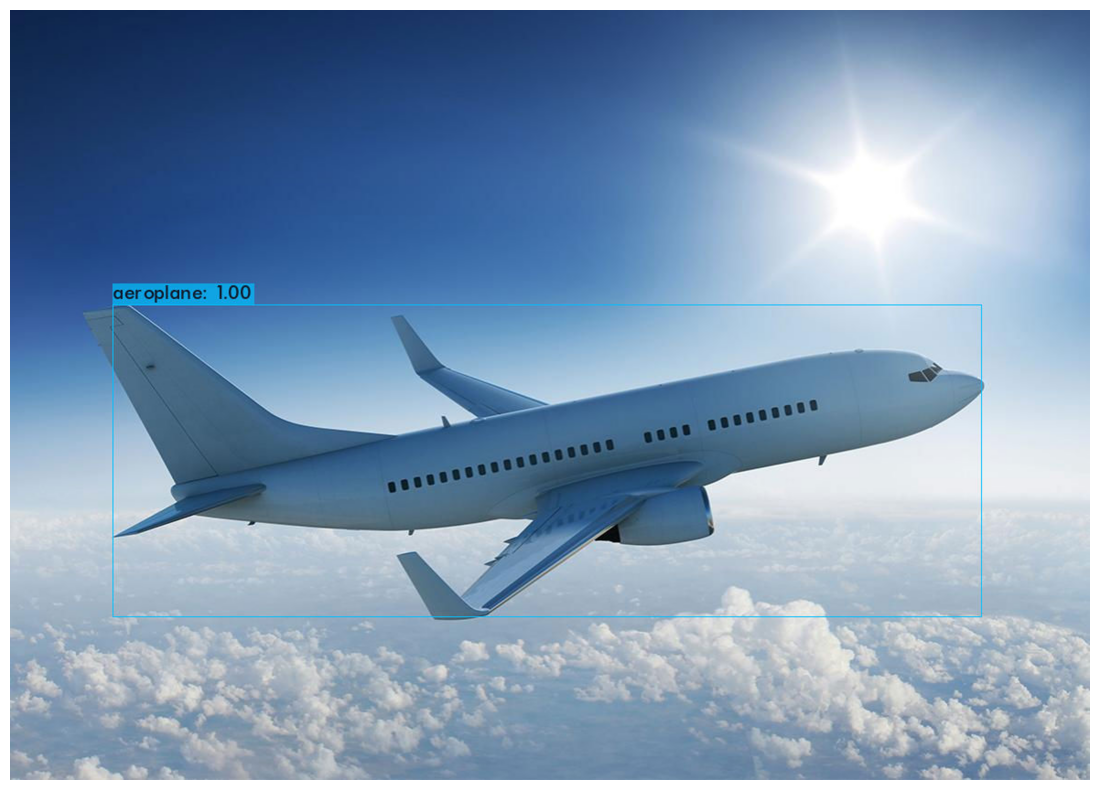

In [42]:
# run darknet command with google drive image (my image path is /images/plane.jpg)
%cd darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights /mydrive/images/plane.jpg
imShow('predictions.jpg')

Download Files to Local Machine or Google Drive from Cloud VM

In [43]:
# LOCAL MACHINE DOWNLOAD
download('predictions.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# GOOGLE DRIVE DOWNLOAD
!cp predictions.jpg /mydrive/images/detection1.jpg

---------------------------- INIT test video (not working yet) -------------------------------------

In [ ]:
!pwd # most be in here /content/darknet if not do %cd darknet

In [ ]:
!apt install ffmpeg libopencv-dev libgtk-3-dev python-numpy python3-numpy libdc1394-22 libdc1394-22-dev libjpeg-dev libtiff5-dev libavcodec-dev libavformat-dev libswscale-dev libxine2-dev libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev libv4l-dev libtbb-dev qtbase5-dev libfaac-dev libmp3lame-dev libopencore-amrnb-dev libopencore-amrwb-dev libtheora-dev libvorbis-dev libxvidcore-dev x264 v4l-utils unzip

In [ ]:
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights -dont_show test.mp4 -i 0 -out_filename output1.avi -thresh 0.7

---------------------------- FIN test video (not working yet) -------------------------------------

Training a Custom YOLOv3 Object Detector in the Cloud!

In [47]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/YOLO

get_data_from_Googles_Open_Images.ipynb  Untitled0.ipynb  yolov3.ipynb
Table_Chair_Laptop_Person.zip		 Untitled1.ipynb


In [49]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/YOLO/obj.zip ../

In [50]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d data/

Archive:  ../obj.zip
   creating: data/Table_Chair_Laptop_Person/
  inflating: data/Table_Chair_Laptop_Person/e492b0c9118bccaf.jpg  
  inflating: data/Table_Chair_Laptop_Person/88600340a4fc6faa.jpg  
  inflating: data/Table_Chair_Laptop_Person/3c8cdb7c163b2644.jpg  
  inflating: data/Table_Chair_Laptop_Person/bccf5fc77763a47e.jpg  
  inflating: data/Table_Chair_Laptop_Person/7d5f88d167c41828.jpg  
  inflating: data/Table_Chair_Laptop_Person/94843bae237af4b4.jpg  
  inflating: data/Table_Chair_Laptop_Person/614364c887f163b3.jpg  
  inflating: data/Table_Chair_Laptop_Person/3c5b36f1a77ba575.jpg  
  inflating: data/Table_Chair_Laptop_Person/9c176864838ecb3f.jpg  
  inflating: data/Table_Chair_Laptop_Person/45cf415bf04e1c75.jpg  
  inflating: data/Table_Chair_Laptop_Person/4e009bb97bde8f0c.jpg  
  inflating: data/Table_Chair_Laptop_Person/8f626397b2767ecb.jpg  
  inflating: data/Table_Chair_Laptop_Person/81eb2a2fbeefbbf5.jpg  
  inflating: data/Table_Chair_Laptop_Person/540570897de0ef3c.jp

Configuring Files for Training

In [52]:
# download cfg to google drive and change its name
!cp cfg/yolov3.cfg /mydrive/YOLO/yolov3_custom2.cfg

Now you need to edit the .cfg to fit your needs based on your object detector. Open it up in a code or text editor to do so.

I recommend having batch = 64 and subdivisions = 16 for ultimate results. If you run into any issues then up subdivisions to 32.

Note: I set my max_batches = 10000, steps = 8000, 9000, I changed the classes = 5 in the three YOLO layers and filters = 30 in the three convolutional layers before the YOLO layers.